# Hierarchical Linear Regression (Radon Contamination dataset)

In this example we want to revisit the classical example of hierarchical linear regression model based on the dataset of the *Radon Contamination* by Gelman and Hill. In particular, we want to show how to easy is to port the [`pymc`](https://docs.pymc.io/en/v3/) models, presented in the very complete article [A Primer on Bayesian Methods for Multilevel Modeling](https://docs.pymc.io/projects/examples/en/latest/case_studies/multilevel_modeling.html), to [`bambi`](https://bambinos.github.io/bambi/main/index.html) using the formula specification for the models.

## Prepare Notebook

In [1]:
import arviz as az
from bambi import Model
from bambi import Prior
import numpy as np
import pandas as pd
import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns
az.style.use("arviz-darkgrid")
np.random.default_rng(8924)

%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = "svg"

## Read Data

Let us load the data into a pandas dataframe.

In [2]:
path = "https://raw.githubusercontent.com/pymc-devs/pymc-examples/main/examples/data/srrs2.dat"

srrs2 = pd.read_csv(path, sep=",",  on_bad_lines='skip')

## Preprocess Data

Let us start by preprocessing the data as done in the article [A Primer on Bayesian Methods for Multilevel Modeling](https://docs.pymc.io/projects/examples/en/latest/case_studies/multilevel_modeling.html). We want to keep the same notation as in the article.

In [3]:
# TODO: Organize this pre-processing steps and keep just the relevant ones.

# Filter data for state `MN`
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state == "MN"].copy()

# Compute fips
srrs_mn["fips"] = srrs_mn.stfips * 1000 + srrs_mn.cntyfips

# Get city data
cty = pd.read_csv(pm.get_data("cty.dat"))
cty_mn = cty[cty.st == "MN"].copy()
cty_mn["fips"] = 1000 * cty_mn.stfips + cty_mn.ctfips

# Merge data
srrs_mn = srrs_mn.merge(cty_mn[["fips", "Uppm"]], on="fips")
srrs_mn = srrs_mn.drop_duplicates(subset="idnum")
u = np.log(srrs_mn.Uppm).unique()

n = len(srrs_mn)

# Get lookup table for counties
srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(counties)))

# local copies of variables
county = srrs_mn["county_code"] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn["log_radon"] = log_radon = np.log(radon + 0.1).values
floor = srrs_mn.floor.values

srrs_mn.sort_values(by="floor", inplace=True)

## Models: Conventional Approaches

### Complete Pooling

Let us start by considering the complete pooling model on which we treat all counties the same, and estimate a single radon level. That is, 

$$y_i = \alpha + \beta x_i + \epsilon_i$$

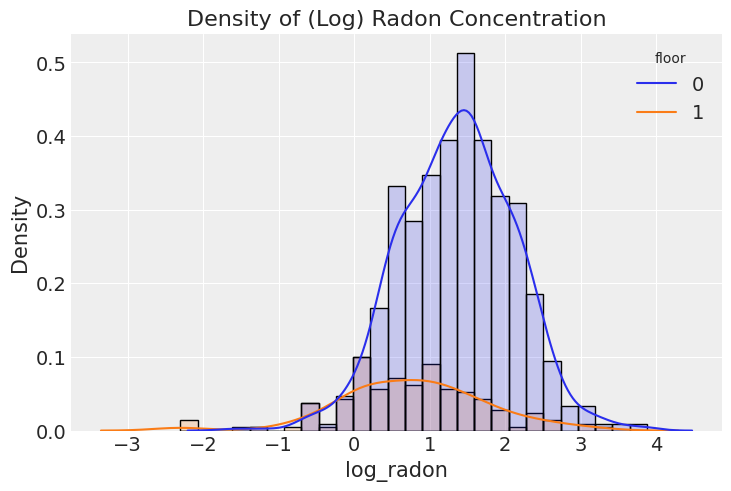

In [4]:
fig, ax = plt.subplots()
sns.histplot(x="log_radon", hue="floor", alpha=0.2, stat="density", data=srrs_mn, ax=ax)
sns.kdeplot(x="log_radon", hue="floor", data=srrs_mn, ax=ax)
ax.set(title="Density of (Log) Radon Concentration", ylabel="Density");

In [5]:
pooled_priors = {
    "Intercept": Prior(name="Normal", mu=0.0, sigma=10.0),
    "floor": Prior(name="Normal", mu=0.0, sigma=10.0),
    "sigma": Prior(name="Exponential", lam=1.0),
}

pooled_model = Model(
    formula="log_radon ~ floor",
    data=srrs_mn,
    priors=pooled_priors,
    family="gaussian",
    link="identity",
)

pooled_model

Formula: log_radon ~ floor
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0.0, sigma: 10.0)
    floor ~ Normal(mu: 0.0, sigma: 10.0)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1.0)

In [6]:
pooled_results = pooled_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_radon_sigma, floor, Intercept]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


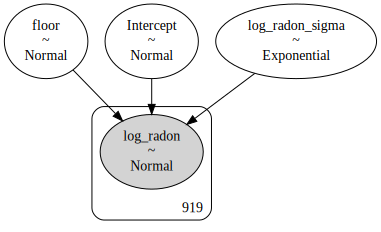

In [7]:
pm.model_to_graphviz(pooled_model.backend.model)

In [8]:
az.summary(data=pooled_results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.363,0.028,1.312,1.415,0.000,0.000,5092.0,2821.0,1.0
floor,-0.586,0.070,-0.719,-0.459,0.001,0.001,5677.0,3271.0,1.0
log_radon_sigma,0.791,0.018,0.756,0.825,0.000,0.000,5280.0,3032.0,1.0


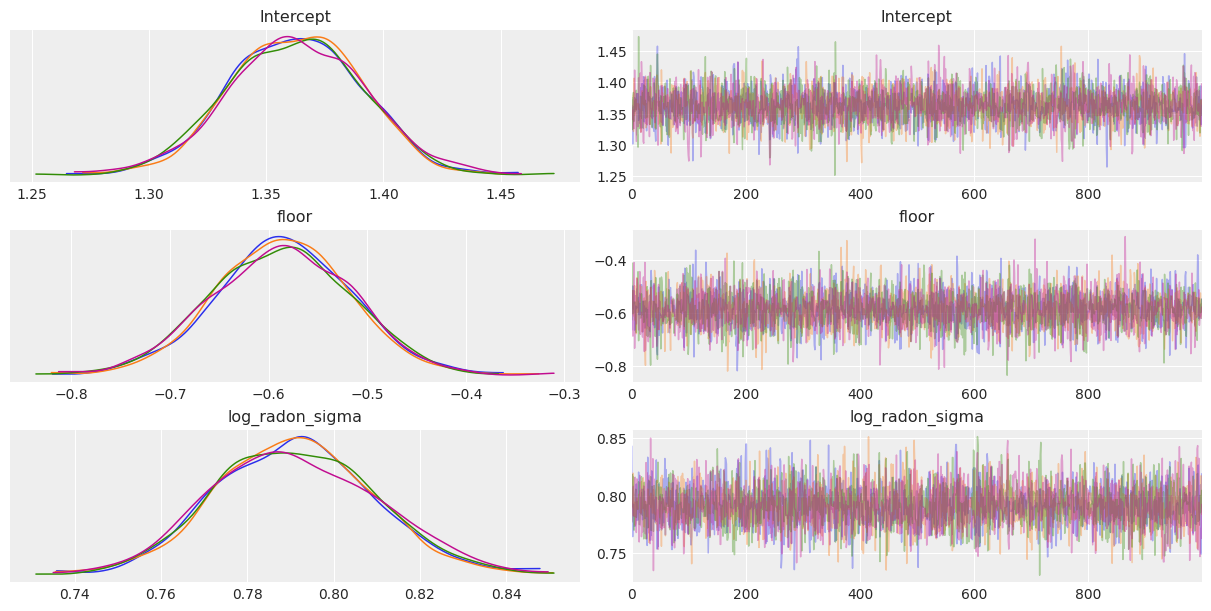

In [9]:
az.plot_trace(data=pooled_results, compact=False);

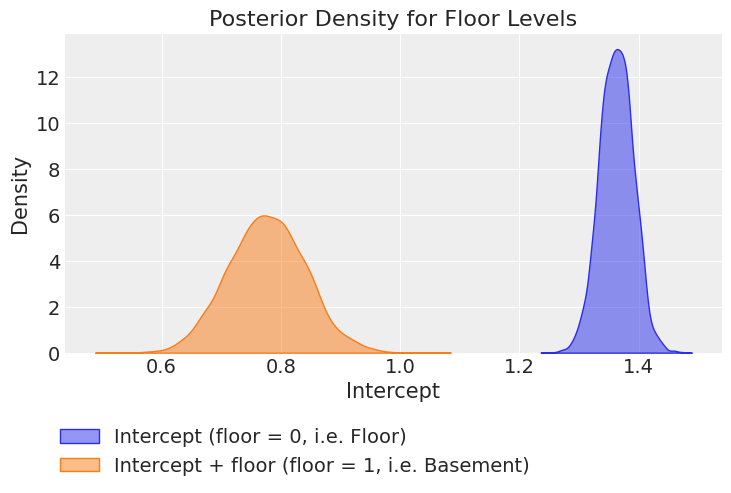

In [10]:
pooled_results_posterior_stacked = pooled_results.posterior.stack(sample=('chain', 'draw'))

fig, ax = plt.subplots()
sns.kdeplot(
    x=pooled_results_posterior_stacked ["Intercept"],
    fill=True,
    alpha=0.5,
    label="Intercept (floor = 0, i.e. Floor)",
    ax=ax
);
sns.kdeplot(
    x=(pooled_results_posterior_stacked ["Intercept"]
        + pooled_results_posterior_stacked ["floor"]),
    fill=True,
    alpha=0.5,
    label="Intercept + floor (floor = 1, i.e. Basement)",
    ax=ax
)
ax.legend(loc="upper left")
ax.legend(loc='upper center', bbox_to_anchor=(0.35, -0.18))
ax.set(title="Posterior Density for Floor Levels", ylabel="Density");

### No Pooling

Nex, we consider the model in which radon is modeled in each county independently, i.e. 

$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$

where $j = 1,\ldots,85$



In [11]:
unpooled_priors = {
    "county": Prior(name="Normal", mu=0.0, sigma=10.0),
    "county:floor": Prior(name="Normal", mu=0.0, sigma=10.0),
    "sigma": Prior(name="Exponential", lam=1.0),
}

unpooled_model = Model(
    formula="log_radon ~ 0 + county + county:floor",
    data=srrs_mn,
    priors=unpooled_priors,
    family="gaussian",
    link="identity",
    auto_scale=False,
 )

unpooled_model

Formula: log_radon ~ 0 + county + county:floor
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    county ~ Normal(mu: 0.0, sigma: 10.0)
    county:floor ~ Normal(mu: 0.0, sigma: 10.0)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1.0)

In [12]:
unpooled_results = unpooled_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_radon_sigma, county:floor, county]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.


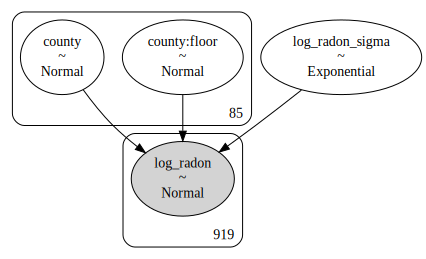

In [13]:
pm.model_to_graphviz(unpooled_model.backend.model)

In [14]:
az.summary(data=unpooled_results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
county[AITKIN],0.668,0.416,-0.121,1.442,0.005,0.004,6778.0,2827.0,1.0
county[ANOKA],0.955,0.101,0.761,1.138,0.001,0.001,7696.0,2901.0,1.0
county[BECKER],1.470,0.699,0.192,2.817,0.008,0.006,7771.0,3127.0,1.0
county[BELTRAMI],1.720,0.409,0.936,2.465,0.004,0.003,9767.0,3229.0,1.0
county[BENTON],1.339,0.410,0.596,2.116,0.005,0.003,7886.0,3527.0,1.0
...,...,...,...,...,...,...,...,...,...
county:floor[WILKIN],0.140,10.332,-18.284,20.362,0.115,0.205,8107.0,2525.0,1.0
county:floor[WINONA],-1.981,0.480,-2.906,-1.095,0.006,0.004,6853.0,3242.0,1.0
county:floor[WRIGHT],-0.793,0.752,-2.229,0.549,0.009,0.008,7216.0,2809.0,1.0
county:floor[YELLOW MEDICINE],-0.048,10.019,-18.907,18.672,0.112,0.186,7974.0,2653.0,1.0


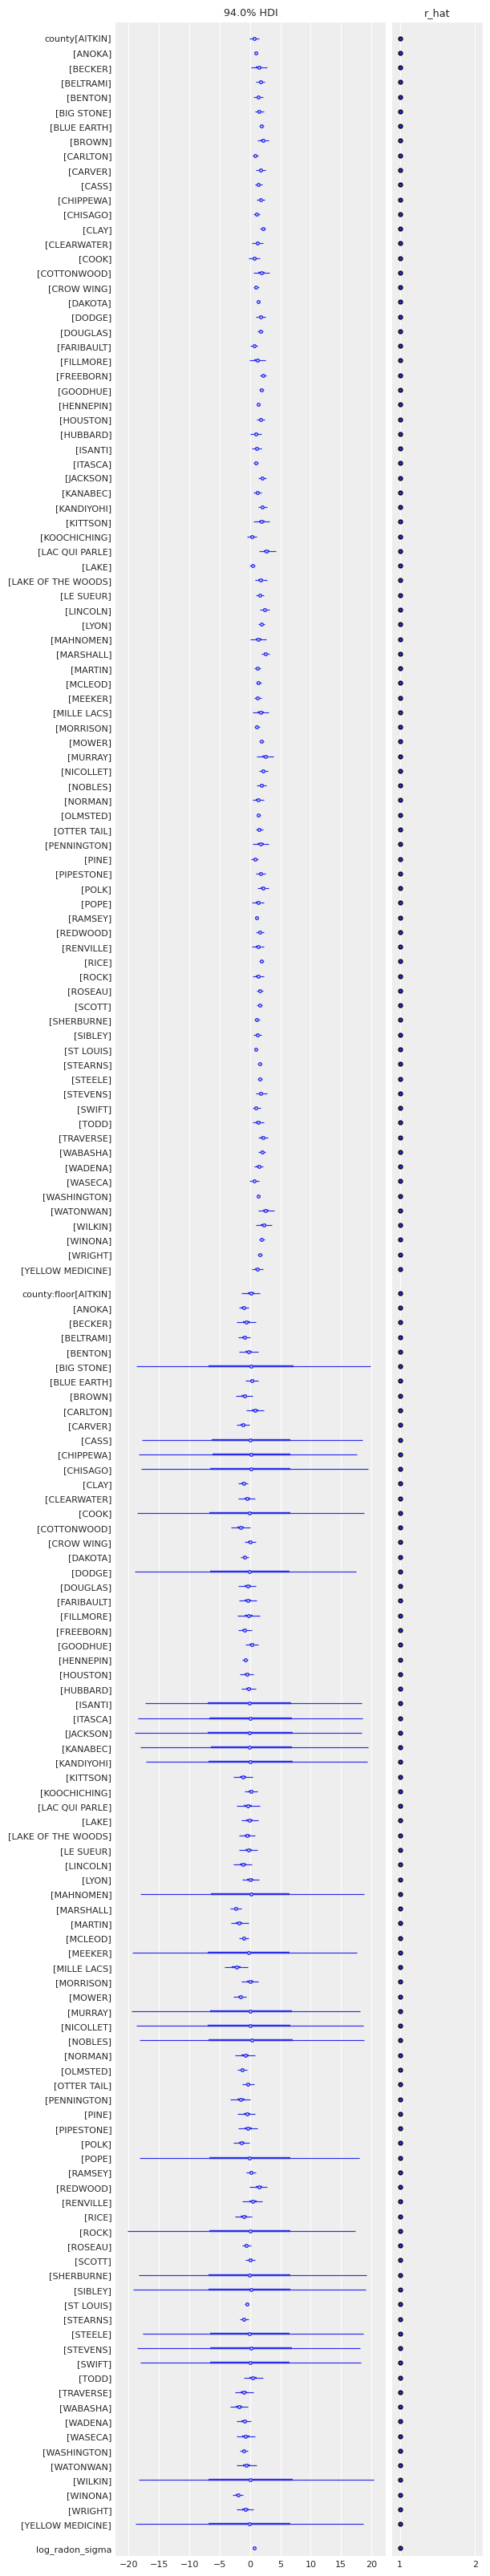

In [15]:
az.plot_forest(data=unpooled_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

## Multilevel and Hierarchical Models

### Partial Pooling Model

$$y_i = \alpha_{j[i]} + \epsilon_i$$

where

$$\epsilon_i \sim N(0, \sigma_y^2)$$

and the intercept random effect:

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$

In [16]:
partial_pooling_priors = {
    "1|county": Prior(name="Normal", mu=0.0, sigma=10.0),
    "sigma": Prior(name="Exponential", lam=1.0),
}

partial_pooling_model = Model(
    formula="log_radon ~ 0 + (0 + 1|county)",
    data=srrs_mn,
    priors=partial_pooling_priors,
    family="gaussian",
    link="identity",
    auto_scale=False,
 )

partial_pooling_model

Formula: log_radon ~ 0 + (0 + 1|county)
Family name: Gaussian
Link: identity
Observations: 919
Priors:


  Group-level effects
    1|county ~ Normal(mu: 0.0, sigma: 10.0)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1.0)

In [17]:
partial_pooling_results = partial_pooling_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_radon_sigma, 1|county]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


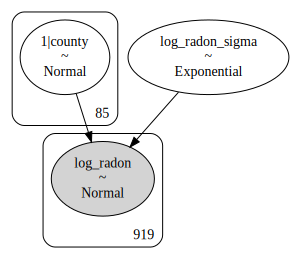

In [18]:
pm.model_to_graphviz(partial_pooling_model.backend.model)

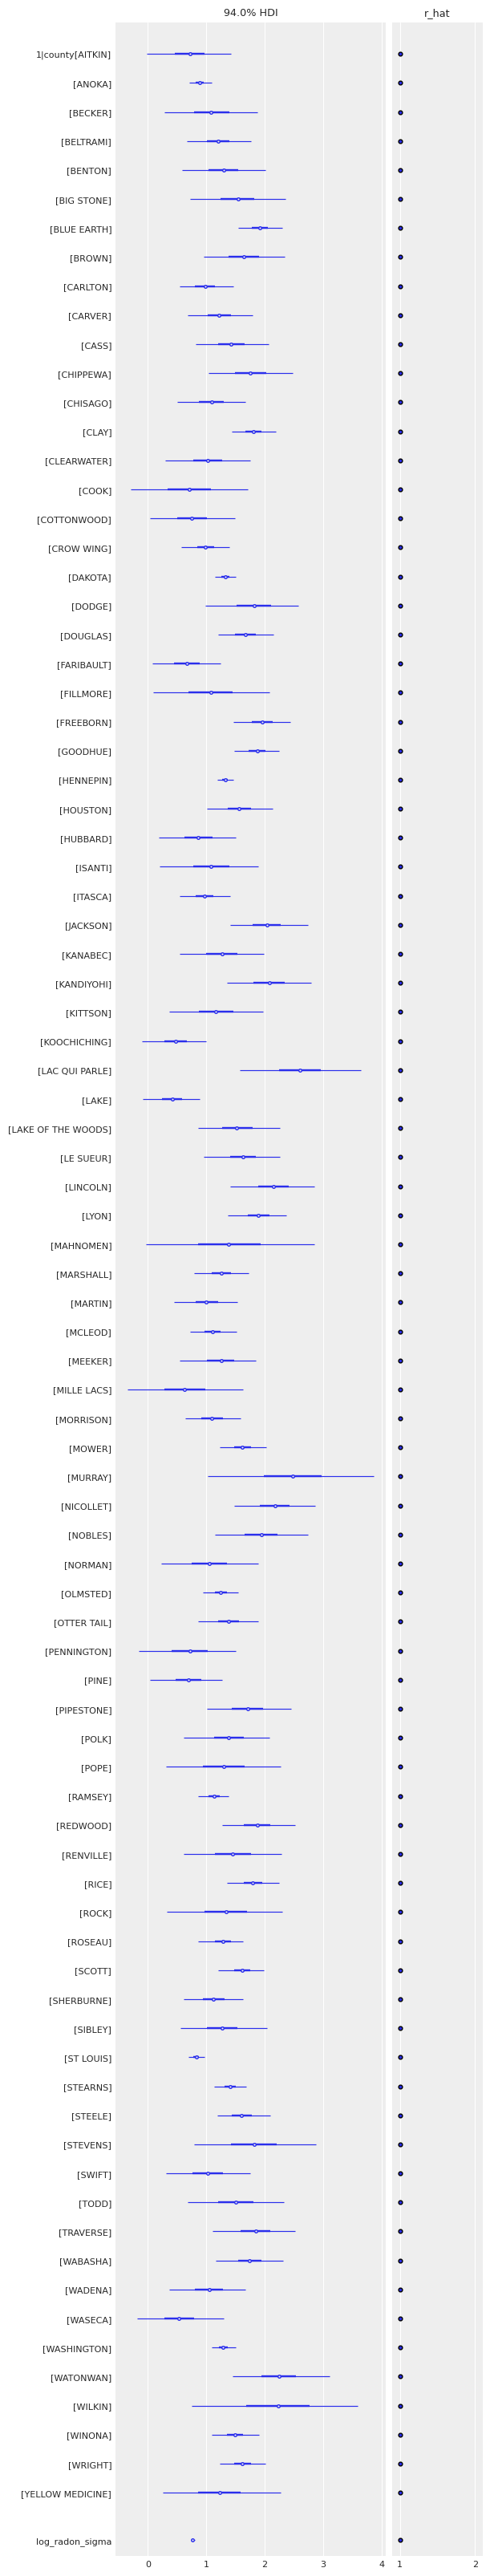

In [19]:
az.plot_forest(data=partial_pooling_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

### Varying Intercept Model

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

where

$$\epsilon_i \sim N(0, \sigma_y^2)$$

and the intercept random effect:

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$

In [20]:
varying_intercept_priors = {
    "floor": Prior(name="Normal", mu=0.0, sigma=10.0),
    "1|county": Prior(name="Normal", mu=0.0, sigma=10.0),
    "sigma": Prior(name="Exponential", lam=1.0),
}

varying_intercept_model = Model(
    formula="log_radon ~ 0 + (1|county) + floor", # ! How to do complete one-hot-encoding for county?
    data=srrs_mn,
    priors=varying_intercept_priors,
    family="gaussian",
    link="identity",
 )

varying_intercept_model

Formula: log_radon ~ 0 + (1|county) + floor
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    floor ~ Normal(mu: 0.0, sigma: 10.0)

  Group-level effects
    1|county ~ Normal(mu: 0.0, sigma: 10.0)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1.0)

In [21]:
varying_intercept_results = varying_intercept_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_radon_sigma, 1|county, floor]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


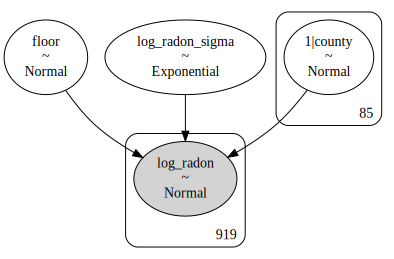

In [22]:
pm.model_to_graphviz(varying_intercept_model.backend.model)

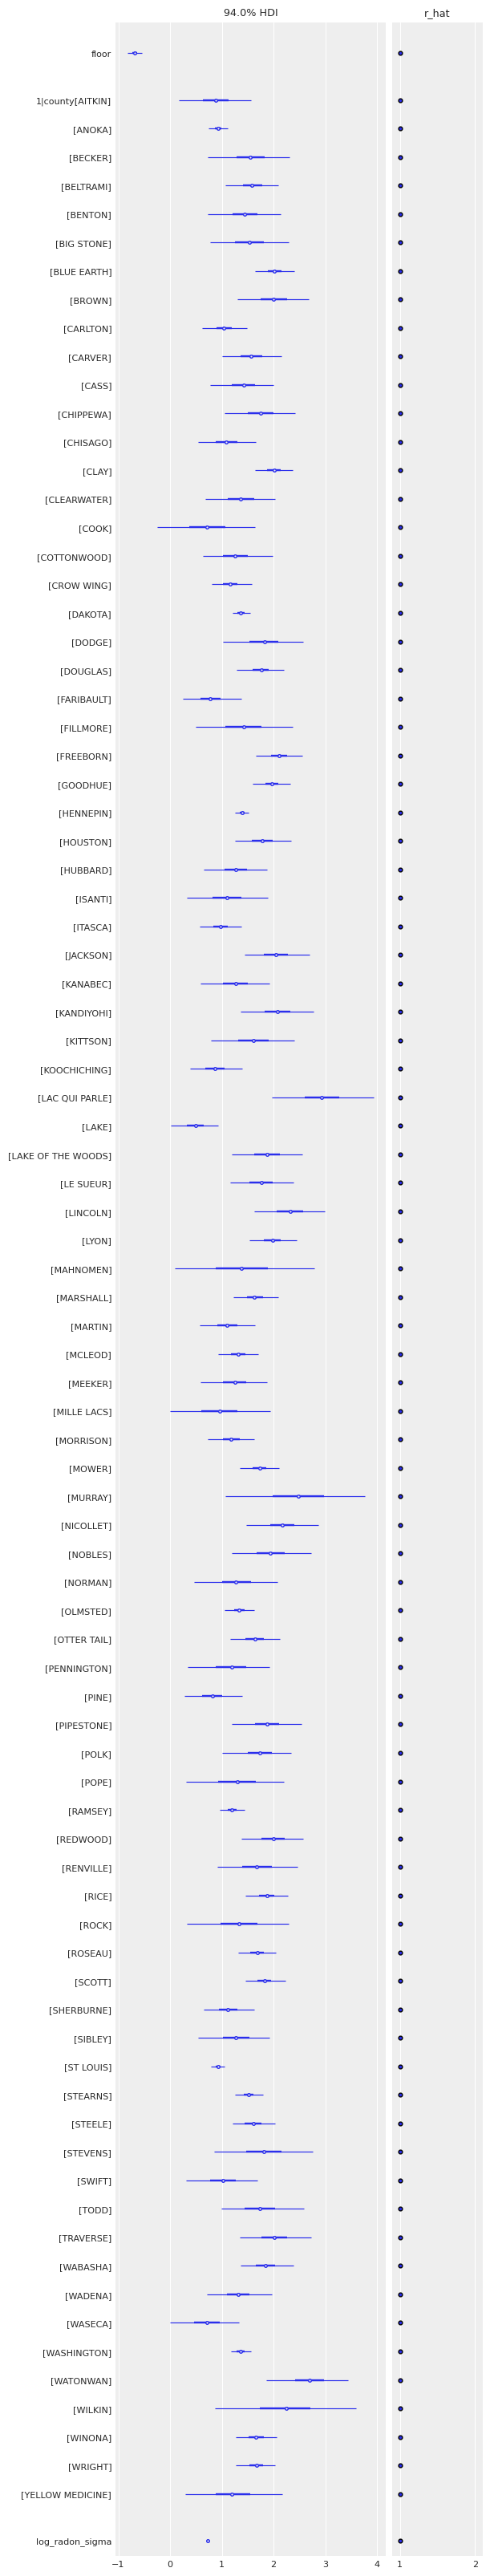

In [23]:
az.plot_forest(data=varying_intercept_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

### Varying Intercept and Slope Model

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_{i} + \epsilon_i$$

In [24]:
varying_intercept_slope_priors = {
    "floor|county": Prior(name="Normal", mu=0.0, sigma=10.0),
    "sigma": Prior(name="Exponential", lam=1.0),
}

varying_intercept_slope_model = Model(
    formula="log_radon ~ 0 + (floor|county)", # ! How to do complete one-hot-encoding for county?
    data=srrs_mn,
    priors=varying_intercept_slope_priors,
    family="gaussian",
    link="identity",
 )

varying_intercept_slope_model

Formula: log_radon ~ 0 + (floor|county)
Family name: Gaussian
Link: identity
Observations: 919
Priors:


  Group-level effects
    1|county ~ Normal(mu: 0, sigma: HalfNormal(sigma: 2.0473))
    floor|county ~ Normal(mu: 0.0, sigma: 10.0)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1.0)

In [25]:
varying_intercept_slope_results = varying_intercept_slope_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_radon_sigma, floor|county, 1|county_offset, 1|county_sigma]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
The number of effective samples is smaller than 25% for some parameters.


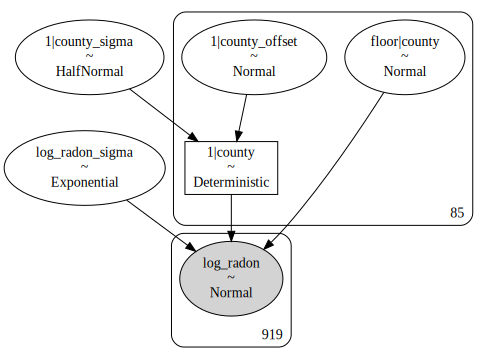

In [26]:
pm.model_to_graphviz(varying_intercept_slope_model.backend.model)

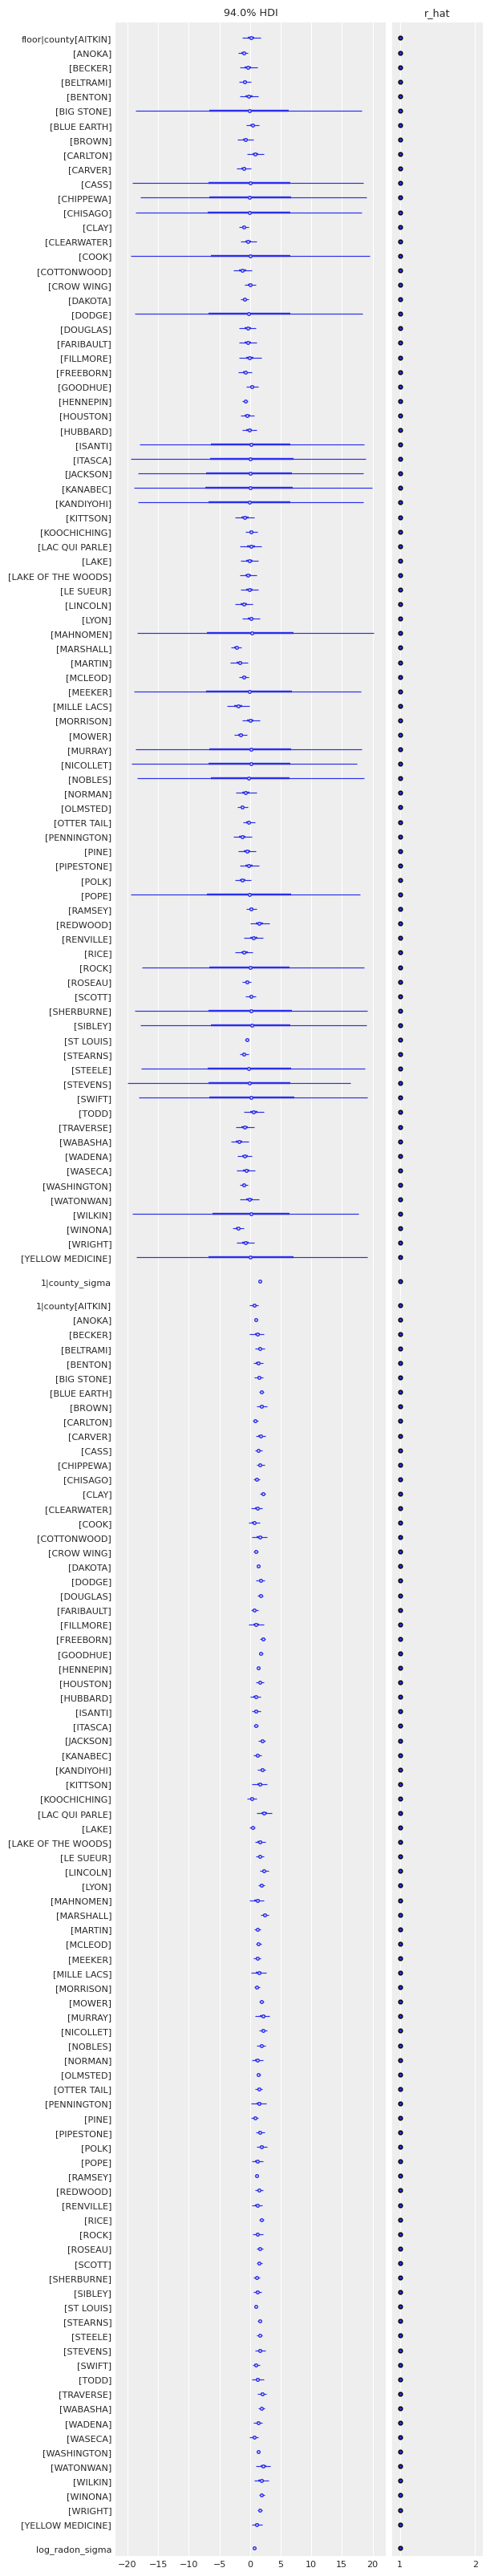

In [27]:
az.plot_forest(data=varying_intercept_slope_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);